In [ ]:
# Description: Plot Figure 9 (coherences between area-averaged, daily vorticity terms)
#
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        April/2020

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from xarray import open_dataset
from pandas import Series
from scipy import signal
from scipy.special import erfinv

In [3]:
class Spectrum(object):
    """
    A class that represents a single realization of
    the one-dimensional spectrum  of a given field phi
    """
    def __init__(self, phi, dt, window=None, beta=14, demean=True, detrend=True, prewhiten=False, normalize=True):
        """
        'window' must be one of 'hanning', 'hamming',
        'kaiser' or 'bartlett'.

        'beta' is the shape parameter of the Kaiser window
        (defaults to 14), if the Kaiser window is used.
        """
        self.phi = phi      # field to be analyzed
        self.dt = dt        # sampling interval
        self.n = phi.size

        # test if n is even
        if (self.n%2):
            self.neven = False
        else:
            self.neven = True

        # calculate frequencies
        self.calc_freq()

        # calculate spectrum
        self.calc_spectrum(window=window, beta=beta, demean=demean, detrend=detrend, prewhiten=prewhiten, normalize=normalize)

        # calculate total var
        self.calc_var()

    def calc_freq(self):
        """ calculate array of spectral variable (frequency or
                wavenumber) in cycles per unit of L """

        self.df = 1./((self.n-1)*self.dt)

        if self.neven:
            self.f = self.df*np.arange(self.n/2+1)
        else:
            self.f = self.df*np.arange( (self.n-1)/2.  + 1 )

    def calc_spectrum(self, window=None, beta=14, demean=True, detrend=True, prewhiten=False, normalize=True):
        """ compute the 1d spectrum of a field phi """

        phi_aux = self.phi.copy() # Copy series to store only the original as Spectrum.phi

        if demean:
            phi_aux = phi_aux - phi_aux.mean()

        if detrend:
            phi_aux = signal.detrend(phi_aux, type='linear')

        if prewhiten:
            phi_aux = (phi_aux[1:] - phi_aux[:-1])/self.dt

        # Window the variable before calculating the FFT.
        if window:
            wdws = {'hanning':np.hanning, 'hamming':np.hamming, \
            'kaiser':np.kaiser, 'bartlett':np.bartlett}
            if window=='kaiser':
                win =  wdws[window](self.n, beta)
            else:
                win =  wdws[window](self.n)

            # The normalization below satisfies Parseval's Theorem with synthetic data.
            if window=='kaiser':
                print("Normalization not implemented for Kaiser window yet.")
                stop
            else:
                winfac = {'hanning':np.sqrt(8/3.),'hamming':np.sqrt(2.5164),'bartlett':np.sqrt(3.)} # Thomson & Emery (2014), p. 479, table 5.5.
            win = win*winfac[window]
            phi_aux *= win

        self.phih = np.fft.rfft(phi_aux)

        # the factor of 2 comes from the symmetry of the Fourier coeffs
        if normalize:
            self.spec = 2.*(self.phih*self.phih.conj()).real / self.df / self.n**2
        else:
            self.spec = 2.*(self.phih*self.phih.conj()).real / self.df

        # the zeroth frequency should be counted only once
        self.spec[0] = self.spec[0]/2.
        if self.neven:
            self.spec[-1] = self.spec[-1]/2.

        if prewhiten:
            faux = self.f[1:]
            self.spec = self.spec/(2*np.pi*faux)**2 # Re--redden the spectrum.
            self.f = self.f[:-1]

    def calc_var(self):
        """ Compute total variance from spectrum """
        self.var = self.df*self.spec[1:].sum() # do not consider zeroth frequency


class xSpectrum(object):
    """
    A class that represents a single realization of
    the one-dimensional cross-spectrum of two given fields phi1 and phi2.
    """
    def __init__(self, phi1, phi2, dt, window=None, beta=14, demean=True,
    detrend=True, normalize=True):
        """
        'window' must be one of 'hanning', 'hamming',
        'kaiser' or 'bartlett'.

        'beta' is the shape parameter of the Kaiser window
        (defaults to 14), if the Kaiser window is used.
        """
        assert phi1.size==phi2.size, "The two fields have different sizes."
        self.phi1 = phi1    # First field to be analyzed
        self.phi2 = phi2    # Second field to be analyzed
        self.dt = dt        # sampling interval
        self.n = phi1.size

        # test if n is even
        if (self.n%2):
            self.neven = False
        else:
            self.neven = True

        # calculate frequencies
        self.calc_freq()

        # calculate cross-spectrum
        self.calc_xspectrum(window=window, beta=beta, demean=demean, detrend=detrend, normalize=normalize)

        # calculate total var
        self.calc_var()

    def calc_freq(self):
        """ calculate array of spectral variable (frequency or
                wavenumber) in cycles per unit of L """

        self.df = 1./((self.n-1)*self.dt)

        if self.neven:
            self.f = self.df*np.arange(self.n/2+1)
        else:
            self.f = self.df*np.arange( (self.n-1)/2.  + 1 )

    def calc_xspectrum(self, window=None, beta=14, demean=True, detrend=True, normalize=True):
        """compute the 1d cross-spectrum of two fields phi1 and phi2"""

        phi_aux1 = self.phi1.copy() # Copy series to store only the original as Spectrum.phi
        phi_aux2 = self.phi2.copy()

        if demean:
            phi_aux1 = phi_aux1 - phi_aux1.mean()
            phi_aux2 = phi_aux2 - phi_aux2.mean()

        if detrend:
            phi_aux1 = signal.detrend(phi_aux1, type='linear')
            phi_aux2 = signal.detrend(phi_aux2, type='linear')

        # Window the variable before calculating the FFT.
        if window:
            wdws = {'hanning':np.hanning, 'hamming':np.hamming, \
            'kaiser':np.kaiser, 'bartlett':np.bartlett}
            if window=='kaiser':
                win =  wdws[window](self.n, beta)
            else:
                win =  wdws[window](self.n)

            # The normalization below satisfies Parseval's Theorem with synthetic data, the ones above do not.
            if window=='kaiser':
                print("Normalization not implemented for Kaiser window yet.")
                stop
            else:
                winfac = {'hanning':np.sqrt(8/3.),'hamming':np.sqrt(2.5164),'bartlett':np.sqrt(3.)} # Thomson & Emery (2014), p. 479, table 5.5.
            win = win*winfac[window]
            phi_aux1 *= win
            phi_aux2 *= win

        self.phih1 = np.fft.rfft(phi_aux1)
        self.phih2 = np.fft.rfft(phi_aux2)

        # the factor of 2 comes from the symmetry of the Fourier coeffs
        if normalize:
            self.xspec = 2.*self.phih1*self.phih2.conj() / self.df / self.n**2
        else:
            self.xspec = 2.*self.phih1*self.phih2.conj() / self.df

        # the zeroth frequency should be counted only once
        self.xspec[0] = self.xspec[0]/2.
        if self.neven:
            self.xspec[-1] = self.xspec[-1]/2.

    def calc_var(self):
        """ Compute total variance from cross-spectrum """
        self.var = self.df*self.xspec[1:].sum() # do not consider zeroth frequency


def coherence(phi1, phi2, dt, demean=True, detrend=True, N=10, overlap=0.5, window='hanning', beta=14, verbose=True):
    """
    Calculates the 1D coherence between two variables 'phi1' and 'phi2'
    with the block averaging method.

    'N' is the intended number of blocks to split the time series in,
    in the case of no overlap. For nonzero overlap, the actual number of
    blocks will be the maximum possible considering the size of 'phi'.

    'overlap' sets the amount of overlap (in fractional lenght of each block).

    'window' and 'beta' are passed as kwargs to the
    'xSpectrum' class and applied for each block individually.

    REFERENCE
    ---------
    Thomson & Emery (2014), p. 503
    """
    phi1, phi2 = map(np.asanyarray, (phi1, phi2))
    assert phi1.size==phi2.size, "The two fields have different sizes."

    n = phi1.size
    ni = int(n/N)                    # Number of data points in each chunk.
    dn = int(round(ni - overlap*ni)) # How many indices to move forward with each chunk (depends on the % overlap).

    if demean:
        phi1 = phi1 - phi1.mean()
        phi2 = phi2 - phi2.mean()

    if detrend:
        phi1 = signal.detrend(phi1, type='linear')
        phi2 = signal.detrend(phi2, type='linear')

    kwspec = {'window':window, 'beta':beta, 'demean':True, 'detrend':True, 'prewhiten':False, 'normalize':False}
    kwxspec = {'window':window, 'beta':beta, 'demean':True, 'detrend':True, 'normalize':False}
    nblks=0
    i0, i1 = 0, ni
    while i1<=n:
        if nblks==0:
            Sphi1 = Spectrum(phi1[i0:i1], dt, **kwspec) # normalize=False because the normalizations of the cross-spectrum and the two autospectra cancel on the coherence.
            Sphi2 = Spectrum(phi2[i0:i1], dt, **kwspec)
            Sphi1phi2 = xSpectrum(phi1[i0:i1], phi2[i0:i1], dt, **kwxspec)
        else:
            sphi1 = Spectrum(phi1[i0:i1], dt, **kwspec) # normalize=False because the normalizations of the cross-spectrum and the two autospectra cancel on the coherence.
            sphi2 = Spectrum(phi2[i0:i1], dt, **kwspec)
            sphi1phi2 = xSpectrum(phi1[i0:i1], phi2[i0:i1], dt, **kwxspec)

            # Accumulating cross-spectrum of phi1 and phi2.
            Sphi1phi2.xspec += sphi1phi2.xspec
            # Accumulating autospectra of phi1 and phi2
            Sphi1.spec += sphi1.spec
            Sphi2.spec += sphi2.spec
        i0+=dn; i1+=dn; nblks+=1
    else:
        Sphi1.spec = Sphi1.spec/nblks             # Average the individual spectral realizations.
        Sphi1.spec = Sphi1.spec/ni**2             # Normalize the spectrum by N^2 to enforce Parseval's Theorem (to avoid losing accuracy in normalizing individual estimates).
        Sphi1.var = Sphi1.df*Sphi1.spec[1:].sum() # Update the total variance to reflect the windowed and block-averaged spectrum.

        Sphi2.spec = Sphi2.spec/nblks
        Sphi2.spec = Sphi2.spec/ni**2
        Sphi2.var = Sphi2.df*Sphi2.spec[1:].sum()

        Sphi1phi2.xspec = Sphi1phi2.xspec/nblks
        Sphi1phi2.xspec = Sphi1phi2.xspec/ni**2
        Sphi1phi2.var = Sphi1phi2.df*Sphi1phi2.xspec[1:].sum()

        Ncap = n - i0                 # Number of points left out at the end of the series.

    nm = n/(ni/2.)
    EDoF = {None:nm, 'hanning':(8/3.)*nm, 'hamming':2.5164*nm, 'kaiser':'EDoF not implemented for Kaiser window', 'bartlett':3.*nm} # Thomson & Emery (2014), p. 479, Table 5.5.

    # Calculating coherence from the cross-spectrum of phi1 and phi2 and their autospectra.
    # Calculating the amplitude and phase lag information as the coherence magnitude and a
    # phase spectrum, respectively (e.g., Thomson & Emery, 2014, Gille et al., 2001).
    Coh = Sphi1phi2.xspec/np.sqrt(Sphi1.spec*Sphi2.spec)
    Coh = (Coh*Coh.conj()).real # SQUARED coherence magnitude, or normalized cross-amplitude spectrum, Thomson & Emery (2014), p. 503.
    Phase = np.arctan2(Sphi1phi2.xspec.imag, Sphi1phi2.xspec.real) # Phase spectrum [radians], Thomson & Emery (2014), p. 503.

    # Add the coherence and the phase spectrum to the xSpectrum class that will be returned.
    Sphi1phi2.coherence = Coh
    Sphi1phi2.phase = Phase

    nm = n/(ni/2.)
    EDoF = {None:nm, 'hanning':(8/3.)*nm, 'hamming':2.5164*nm, 'kaiser':'EDoF not implemented for Kaiser window', 'bartlett':3.*nm} # Thomson & Emery (2014), p. 479, Table 5.5.

    if verbose:
        print("")
        print("Left %d data points outside estimate (%.1f %% of the complete series)."%(Ncap,100*Ncap/n))
        print("Intended number of blocks was %d, but could fit %d blocks with %.1f %% overlap."%(N, nblks, 100*overlap))
        print("")
        print("Spectral resolution (original series/block-averaged): %.5f / %.5f [inverse time units]"%(1./(n*dt),1./(ni*dt)))
        print("Fundamental frequency (original series/block-averaged): %.5f / %.5f [inverse time units]"%(1/(n*dt),1/(ni*dt)))
        print("Fundamental period (original series/block-averaged): %.5f / %.5f [time units]"%(n*dt,ni*dt))
        print("")
        print("Nyquist frequency: %.5f [inverse time units]"%(1./(2*dt)))
        print("Nyquist period: %.5f [time units]"%(2*dt))
        print("")
        print("DoF: %d (assuming independent blocks)."%(2*nblks))
        if window:
            print("Equivalent DoF: %d (assuming independent blocks)."%EDoF[window]) # Equivalent DoF for windows.

    return Sphi1phi2, nblks


def coh_err(Cohxy, nblks):
    """
    USAGE
    -----
    Coh_lo, Coh_hi = coh_err(Cohxy, nblks)

    Calculates confidence intervals for the squared cross-amplitude spectrum (Bendat & Piersol, 2010 [chapter 9]).

    'Cohxy' is the block-averaged squared cross-amplitude spectrum (squared coherence magnitude).
    'nblks' is the number of segments used in the block-averaging (DoF/2).

    Returns the low and high 95 % confidence limits of the squared cross-amplitude spectrum ('coh_lo' and 'coh_hi').

    TODO: Generalize confidence limits for arbitrary significance levels.
    """
    Cohxy = np.asarray(Cohxy)
    Cohxysqrt = np.sqrt(Cohxy)

    eps_Cohxy = np.sqrt(2)*(1 - Cohxy)/(Cohxysqrt*np.sqrt(nblks)) # Bendat & Piersol equation (9.82).

    # 95 % Confidence intervals of a Gaussian distribution.
    Cohxy_hi = Cohxy + 2*Cohxy*eps_Cohxy
    Cohxy_lo = Cohxy - 2*Cohxy*eps_Cohxy

    return Cohxy_lo, Cohxy_hi

In [4]:
def crosscorr(x, y, nblks, maxlags=0, overlap=0, onesided=False, verbose=True):
    """
    Lag-N cross correlation averaged with Welch's Method.
    Parameters
    ----------
    x, y     : Arrays of equal length.
    nblks    : Number of blocks to average cross-correlation.
    maxlags  : int, default (0) calculates te largest possible number of lags,
               i.e., the number of points in each chunk.
    overlap  : float, fraction of overlap between consecutive chunks. Default 0.
    onesided : Whether to calculate the cross-correlation only at
               positive lags (default False). Has no effect if
               x and y are the same array, in which case the
               one-sided autocorrelation function is calculated.

    Returns
    ----------
    crosscorr : float array.
    """
    if x is y:
        auto = True
    else:
        auto = False
    x, y = np.array(x), np.array(y)
    nx, ny = x.size, y.size
    assert x.size==y.size, "The series must have the same length"

    nblks, maxlags = int(nblks), int(maxlags)
    ni = int(nx/nblks)               # Number of data points in each chunk.
    dn = int(round(ni - overlap*ni)) # How many indices to move forward with
                                     # each chunk (depends on the % overlap).

    if maxlags==0:
        if verbose:
            print("Maximum lag was not specified. Accomodating it to block size (%d)."%ni)
        maxlags = ni
    elif maxlags>ni:
        if verbose:
            print("Maximum lag is too large. Accomodating it to block size (%d)."%ni)
        maxlags = ni

    if onesided:
        lags = range(maxlags+1)
    else:
        lags = range(-maxlags, maxlags+1)

    # Array that will receive cross-correlation of each block.
    xycorr = np.zeros(len(lags))

    n=0
    il, ir = 0, ni
    while ir<=nx:
        xn = x[il:ir]
        yn = y[il:ir]

        # Calculate cross-correlation for current block up to desired maximum lag - 1.
        xn, yn = map(Series, (xn, yn))
        xycorr += np.array([xn.corr(yn.shift(periods=lagn)) for lagn in lags])

        il+=dn; ir+=dn
        n+=1

    # pandas.Series.corr(method='pearson') -> pandas.nanops.nancorr() ...
    # -> pandas.nanops.get_corr_function() -> np.corrcoef -> numpy.cov(bias=False as default).
    # So np.corrcoef() returns the UNbiased correlation coefficient by default
    # (i.e., normalized by N-k instead of N).

    xycorr /= n    # Divide by number of blocks actually used.
    ncap = nx - il # Number of points left out at the end of array.

    if verbose:
        print("")
        if ncap==0:
            print("No data points were left out.")
        else:
            print("Left last %d data points out (%.1f %% of all points)."%(ncap,100*ncap/nx))
        print("Averaged %d blocks, each with %d lags."%(n,maxlags))
        if overlap>0:
            print("Intended %d blocks, but could fit %d blocks, with"%(nblks,n))
            print('overlap of %.1f %%, %d points per block.'%(100*overlap,dn))
        print("")

    lags = np.array(lags)
    if auto and not onesided:
        fo = np.where(lags==0)[0][0]
        xycorr[fo+1:] = xycorr[fo+1:] + xycorr[:fo]
        lags = lags[fo:]
        xycorr = xycorr[fo:]

    fgud=~np.isnan(xycorr)

    return lags[fgud], xycorr[fgud]




def Tdecorr(Rxx, M=None, dtau=1., verbose=False):
    """
    USAGE
    -----
    Td = Tdecorr(Rxx)

    Computes the integral scale Td (AKA decorrelation scale, independence scale)
    for a data sequence with autocorrelation function Rxx. 'M' is the number of
    lags to incorporate in the summation (defaults to all lags) and 'dtau' is the
    lag time step (defaults to 1).

    The formal definition of the integral scale is the total area under the
    autocorrelation curve Rxx(tau):

    /+inf
    Td = 2 * |     Rxx(tau) dtau
    /0

    In practice, however, Td may become unrealistic if all of Rxx is summed
    (e.g., often goes to zero for data dominated by periodic signals); a
    different approach is to instead change M in the summation and use the
    maximum value of the integral Td(t):

    /t
    Td(t) = 2 * |     Rxx(tau) dtau
    /0

    References
    ----------
    e.g., Thomson and Emery (2014),
    Data analysis methods in physical oceanography,
    p. 274, equation 3.137a.

    Gille lecture notes on data analysis, available
    at http://www-pord.ucsd.edu/~sgille/mae127/lecture10.pdf
    """
    Rxx = np.asanyarray(Rxx)
    C0 = Rxx[0]
    N = Rxx.size # Sequence size.

    # Number of lags 'M' to incorporate in the summation.
    # Sum over all of the sequence if M is not chosen.
    if not M:
        M = N

    # Integrate the autocorrelation function.
    Td = np.zeros(M)
    for m in range(M):
        Tdaux = 0.
        for k in range(m-1):
            Rm = (Rxx[k] + Rxx[k+1])/2. # Midpoint value of the autocorrelation function.
            Tdaux = Tdaux + Rm*dtau # Riemann-summing Rxx.

        Td[m] = Tdaux

    # Normalize the integral function by the autocorrelation at zero lag
    # and double it to include the contribution of the side with
    # negative lags (C is symmetric about zero).
    Td = (2./C0)*Td

    if verbose:
        print("")
        print("Theoretical integral scale --> 2 * int 0...+inf [Rxx(tau)] dtau: %.2f."%Td[-1])
        print("")
        print("Maximum value of the cumulative sum: %.2f."%Td.max())

    return Td


def Tdecorrw(x, nblks=30, ret_median=True, verbose=True):
    """
    USAGE
    -----
    Ti = Tdecorrw(x, nblks=30, ret_median=True, verbose=True)

    'Ti' is the integral timescale calculated from the
    autocorrelation function calculated for variable 'x'
    block-averaged in 'nblks' chunks.
    """
    x = np.array(x)
    dnblkslr = round(nblks/2)

    tis = [Tdecorr(crosscorr(x, x, nblks=n, verbose=verbose)[1]).max() for n in range(nblks-dnblkslr, nblks+dnblkslr+1)]
    tis = np.ma.masked_invalid(tis)

    if verbose:
        print("========================")
        print(tis)
        print("========================")
        p1, p2, p3, p4, p5 = map(np.percentile, [tis]*5, (10, 25, 50, 75, 90))
        print("--> 10 %%, 25 %%, 50 %%, 75 %%, 90 %% percentiles for Ti:  %.2f,  %.2f,  %.2f,  %.2f,  %.2f."%(p1, p2, p3, p4, p5))
        print("------------------------")

    if ret_median:
        return np.median(tis)
    else:
        return tis


def rsig(ndof_eff, alpha=0.95):
	"""
	USAGE
	-----
	Rsig = rsig(ndof_eff, alpha=0.95)

	Computes the minimum (absolute) threshold value 'rsig' that
	the Pearson correlation coefficient r between two normally-distributed
	data sequences with 'ndof_eff' effective degrees of freedom has to have
	to be statistically significant at the 'alpha' (defaults to 0.95)
	confidence level.

	For example, if rsig(ndof_eff, alpha=0.95) = 0.2 for a given pair of
	NORMALLY-DISTRIBUTED samples with a correlation coefficient r>0.7, there
	is a 95 % chance that the r estimated from the samples is significantly
	different from zero. In other words, there is a 5 % chance that two random
	sequences would have a correlation coefficient higher than 0.7.

	OBS: This assumes that the two data series have a normal distribution.

	Translated to Python from the original matlab code by Prof. Sarah Gille
	(significance.m), available at http://www-pord.ucsd.edu/~sgille/sio221c/

	References
	----------
	Gille lecture notes on data analysis, available
	at http://www-pord.ucsd.edu/~sgille/mae127/lecture10.pdf

	Example
	-------
	TODO
	"""
	rcrit_z = erfinv(alpha)*np.sqrt(2./ndof_eff)

	return rcrit_z

In [5]:
plt.close('all')

head_data = "../../data_reproduce_figs/"
terms = ['Ibetav', 'Icurlvdiff', 'Icurlhdiff', 'Istretchp', 'Ires', 'Icurlnonl']
segments = ['Amundsen-Bellingshausen', 'WAP', 'Weddell', 'W-EA', 'E-EA', 'Ross']

# Circumpolar circulation terms.
fname = head_data+'circulation_terms_circumpolar.nc'
ds = open_dataset(fname)

t = ds['t']

# Cross-correlations between terms and autocorrelations.
nblks_coh = 15

fnames = ['circulation_terms-Amundsen-Bellingshausen.nc',
          'circulation_terms-WAP.nc',
          'circulation_terms-Weddell.nc',
          'circulation_terms-W-EA.nc',
          'circulation_terms-E-EA.nc',
          'circulation_terms-Ross.nc',
          'circulation_terms_circumpolar.nc',]

circulation_terms-Amundsen-Bellingshausen.nc *******************************
****************************************

Left 85 data points outside estimate (4.7 % of the complete series).
Intended number of blocks was 15, but could fit 29 blocks with 50.0 % overlap.

Spectral resolution (original series/block-averaged): 0.00055 / 0.00826 [inverse time units]
Fundamental frequency (original series/block-averaged): 0.00055 / 0.00826 [inverse time units]
Fundamental period (original series/block-averaged): 1825.00000 / 121.00000 [time units]

Nyquist frequency: 0.50000 [inverse time units]
Nyquist period: 2.00000 [time units]

DoF: 58 (assuming independent blocks).
Equivalent DoF: 80 (assuming independent blocks).

Left 85 data points outside estimate (4.7 % of the complete series).
Intended number of blocks was 15, but could fit 29 blocks with 50.0 % overlap.

Spectral resolution (original series/block-averaged): 0.00055 / 0.00826 [inverse time units]
Fundamental frequency (original seri

/home/andre/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/andre/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.



Left 85 data points outside estimate (4.7 % of the complete series).
Intended number of blocks was 15, but could fit 29 blocks with 50.0 % overlap.

Spectral resolution (original series/block-averaged): 0.00055 / 0.00826 [inverse time units]
Fundamental frequency (original series/block-averaged): 0.00055 / 0.00826 [inverse time units]
Fundamental period (original series/block-averaged): 1825.00000 / 121.00000 [time units]

Nyquist frequency: 0.50000 [inverse time units]
Nyquist period: 2.00000 [time units]

DoF: 58 (assuming independent blocks).
Equivalent DoF: 80 (assuming independent blocks).
circulation_terms-Weddell.nc *******************************
****************************************

Left 85 data points outside estimate (4.7 % of the complete series).
Intended number of blocks was 15, but could fit 29 blocks with 50.0 % overlap.

Spectral resolution (original series/block-averaged): 0.00055 / 0.00826 [inverse time units]
Fundamental frequency (original series/block-average

/home/andre/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/andre/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.



Left 85 data points outside estimate (4.7 % of the complete series).
Intended number of blocks was 15, but could fit 29 blocks with 50.0 % overlap.

Spectral resolution (original series/block-averaged): 0.00055 / 0.00826 [inverse time units]
Fundamental frequency (original series/block-averaged): 0.00055 / 0.00826 [inverse time units]
Fundamental period (original series/block-averaged): 1825.00000 / 121.00000 [time units]

Nyquist frequency: 0.50000 [inverse time units]
Nyquist period: 2.00000 [time units]

DoF: 58 (assuming independent blocks).
Equivalent DoF: 80 (assuming independent blocks).

Left 85 data points outside estimate (4.7 % of the complete series).
Intended number of blocks was 15, but could fit 29 blocks with 50.0 % overlap.

Spectral resolution (original series/block-averaged): 0.00055 / 0.00826 [inverse time units]
Fundamental frequency (original series/block-averaged): 0.00055 / 0.00826 [inverse time units]
Fundamental period (original series/block-averaged): 1825.0

/home/andre/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/andre/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


circulation_terms-Ross.nc *******************************
****************************************

Left 85 data points outside estimate (4.7 % of the complete series).
Intended number of blocks was 15, but could fit 29 blocks with 50.0 % overlap.

Spectral resolution (original series/block-averaged): 0.00055 / 0.00826 [inverse time units]
Fundamental frequency (original series/block-averaged): 0.00055 / 0.00826 [inverse time units]
Fundamental period (original series/block-averaged): 1825.00000 / 121.00000 [time units]

Nyquist frequency: 0.50000 [inverse time units]
Nyquist period: 2.00000 [time units]

DoF: 58 (assuming independent blocks).
Equivalent DoF: 80 (assuming independent blocks).

Left 85 data points outside estimate (4.7 % of the complete series).
Intended number of blocks was 15, but could fit 29 blocks with 50.0 % overlap.

Spectral resolution (original series/block-averaged): 0.00055 / 0.00826 [inverse time units]
Fundamental frequency (original series/block-averaged):

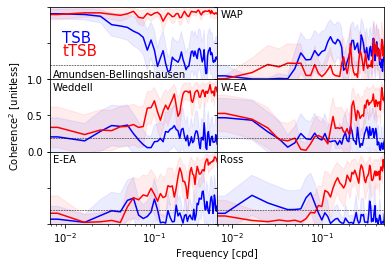

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=2)
axs = axs.flatten()

n=0
for fname in fnames[:-1]:
    print(fname,"*******************************")
    print("****************************************")
    ds = open_dataset(head_data+fname)
    segment = fname.split('terms')[-1].split('.')[0][1:]
    ax = axs[n]

    F = ds['Icurlvdiff'].values
    TSB = -ds['Ibetav'].values - ds['Istretchp'].values # +beta*V +f*w_I, on LHS.
    tTSB = -ds['Ibetav'].values - ds['Istretchp'].values + ds['Ires'].values # +beta*V +f*w_I + dzeta/dt, on LHS.

    DoF = nblks_coh # Conservative
    alpha = 0.05
    coh_alpha_theoretical = 1 - alpha**(1/(DoF - 1)) # Thomson & Emery p. 510, eq. (5.173).

    ax = axs[n]
    cohTSB, _ = coherence(F, TSB, 1, N=nblks_coh)
    cohtTSB, actual_nblks = coherence(F, tTSB, 1, N=nblks_coh)

    cohTSB_lo, cohTSB_hi = coh_err(cohTSB.coherence, nblks_coh)
    cohtTSB_lo, cohtTSB_hi = coh_err(cohtTSB.coherence, nblks_coh)

    ax.semilogx(cohTSB.f, cohTSB.coherence, 'b', label='TSB')
    ax.semilogx(cohtTSB.f, cohtTSB.coherence, 'r', label='tTSB')
    ax.fill_between(cohTSB.f, cohTSB_lo, cohTSB_hi, color='b', alpha=0.075)
    ax.fill_between(cohtTSB.f, cohtTSB_lo, cohtTSB_hi, color='r', alpha=0.075)
    ax.axhline(coh_alpha_theoretical, ls='--', lw=0.5, color='k')

    if n==0:
        xt = 0.075
        ax.text(xt, 0.5, "TSB", color='b', fontsize=15, transform=ax.transAxes)
        ax.text(xt, 0.33, "tTSB", color='r', fontsize=15, transform=ax.transAxes)

    ax.set_ylim(0, 1)
    ax.set_xlim(cohTSB.f[0], cohTSB.f[-1])
    if segment=='Amundsen-Bellingshausen':
        ax.text(0.02, 0.025, segment, transform=ax.transAxes)
    else:
        ax.text(0.02, 0.85, segment, transform=ax.transAxes)

    if n==2:
      ax.set_ylabel('Coherence$^2$ [unitless]')
    elif n==4:
      ax.set_xlabel('Frequency [cpd]', x=1)
    if n in [0,1,3,4,5]:
      ax.set_yticklabels([])

    if n==5:
      fig.subplots_adjust(hspace=0, wspace=0)
      fig.savefig("fig09.png", bbox_inches='tight')
    n += 1

plt.show()